# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [125]:
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
sys.path.append('/content/drive/MyDrive/Prak_MLMI')
sys.path.append('/content/drive/MyDrive')
sys.path.append('/content/drive/MyDrive/Prak_MLMI/model')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.patches as patches

In [ ]:
%%capture
pip install torchray

In [ ]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%reload_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize, Grayscale
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
  
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

label_path = '/content/drive/MyDrive/Prak_MLMI/model/labels'
import cxr_dataset as CXR
import merged_visualize_prediction as V
import pandas as pd

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
#!unzip "/content/drive/MyDrive/NIH_CXR14_Resized.zip" -d "/content/drive/MyDrive/NIH_CXR14_Resized"
# %%timeit
 %%capture
!unzip "/content/drive/MyDrive/Prak_MLMI/NIH_CXR14_Resized.zip" -d /content/

## Loading Data and Model

In [ ]:
prak_dir = '/content/drive/MyDrive/Prak_MLMI'
imagenet_dir = '/content/drive/MyDrive/Prak_MLMI/imagenet'
PATH_TO_IMAGES = "/content/NIH small"
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH_CXR14_Resized/NIH small"
#PATH_TO_IMAGES = prak_dir + "/NIH small"   
#PATH_TO_IMAGES = "/content/drive/MyDrive/NIH small"  
MODEL_PATH = prak_dir + '/model/results/checkpoint_best'
PATH_TO_MODEL = prak_dir + '/model/results/checkpoint_best'


dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

POSITIVE_FINDINGS_ONLY=True
LABEL='Atelectasis'

dataloader, model= V.load_data(PATH_TO_IMAGES, LABEL, PATH_TO_MODEL, 'BBox', POSITIVE_FINDINGS_ONLY, label_path=label_path)
print("Cases for review:")
print(len(dataloader))



# checkpoint = torch.load(MODEL_PATH, map_location=dev)
# model = checkpoint['model'].module
model.to(dev).eval();
print(model)

Cases for review:
180
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### Insert the bottleneck into the model for NIH

You can experiment with the location of the bottleneck.

In [ ]:
iba = IBA(model.features.denseblock2.denselayer6)

In [ ]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [ ]:
iba.estimate(model, dataloader, device=dev, n_samples=10, progbar=True)

## Compare different methods 

In [ ]:
%matplotlib inline

In [ ]:
def visualization_comparison():
# determine rows/columns of the plot, size of each subplot
  size = 12
  rows = 1
  cols = 4

  fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
  methods = ['grad-cam backprop', 'original IB', 'IB with reversed mask']
  p = V.Plotter(dev=dev, informationbottleneck=iba, model=model)
  inputs, labels, filename, bbox, preds = p.plot_map(model, dataloader, LABEL, methods, saliency_layer='features.norm5', axes_a=axes, overlay=True)
  plt.show()
  print(preds)


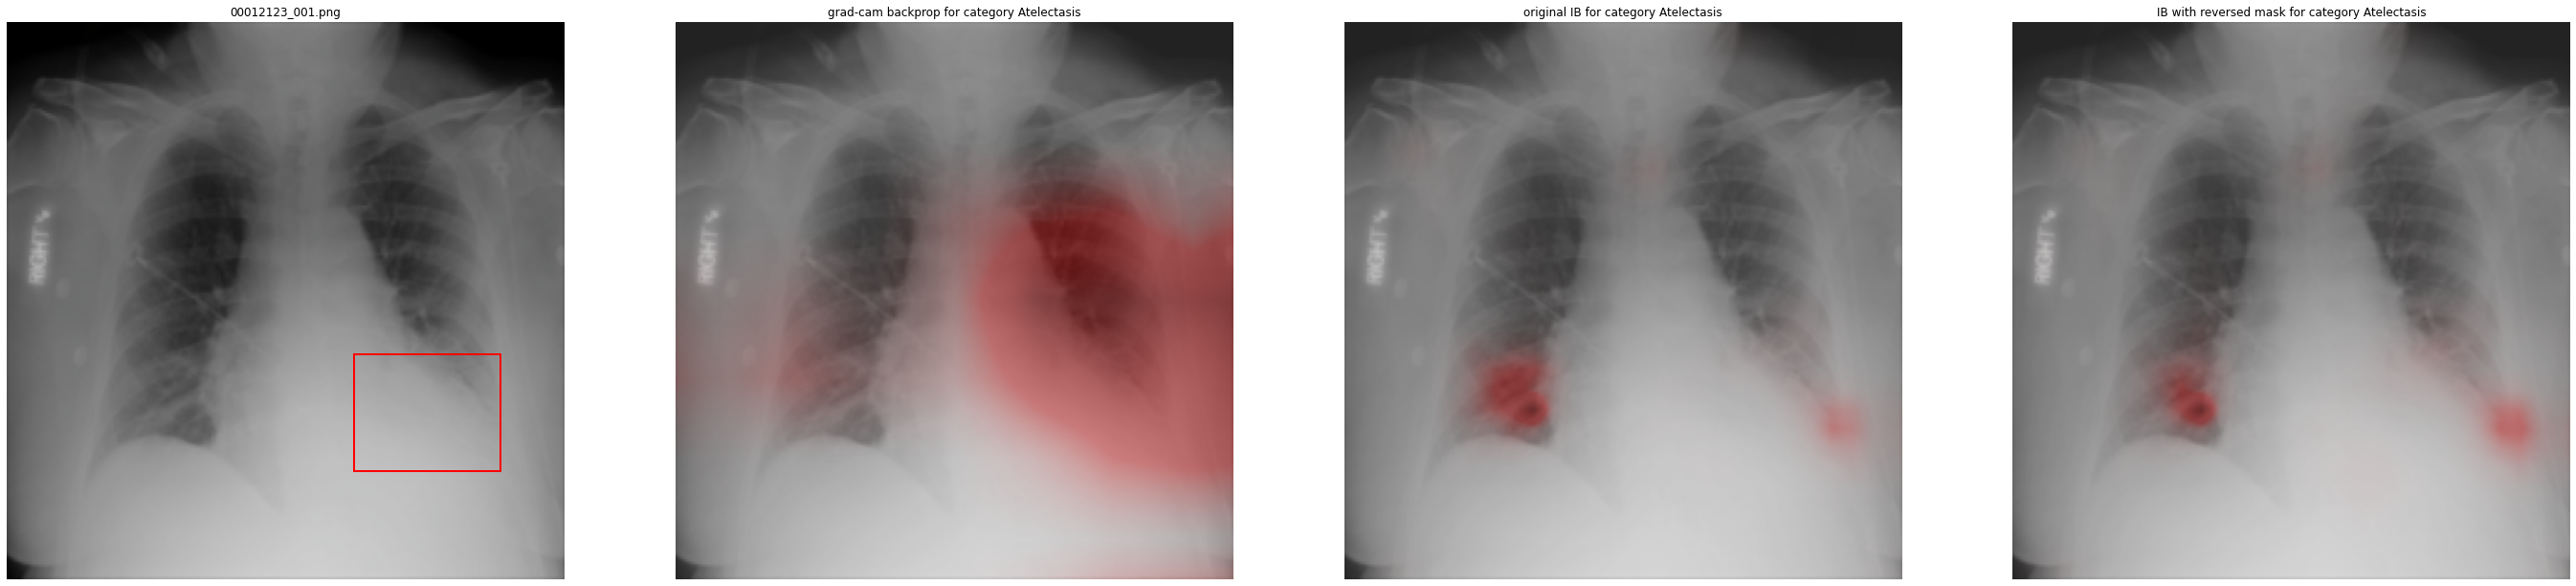

                   Predicted Probability  Ground Truth
Finding                                               
Atelectasis                        0.469          True
Effusion                           0.236          True
Infiltration                       0.198         False
Consolidation                      0.180         False
Cardiomegaly                       0.051         False
Edema                              0.038         False
Nodule                             0.019         False
Pneumonia                          0.019         False
Mass                               0.010         False
Pleural_Thickening                 0.005         False
Pneumothorax                       0.004         False
Emphysema                          0.004         False
Fibrosis                           0.003         False
Hernia                             0.002         False


In [ ]:
visualization_comparison()

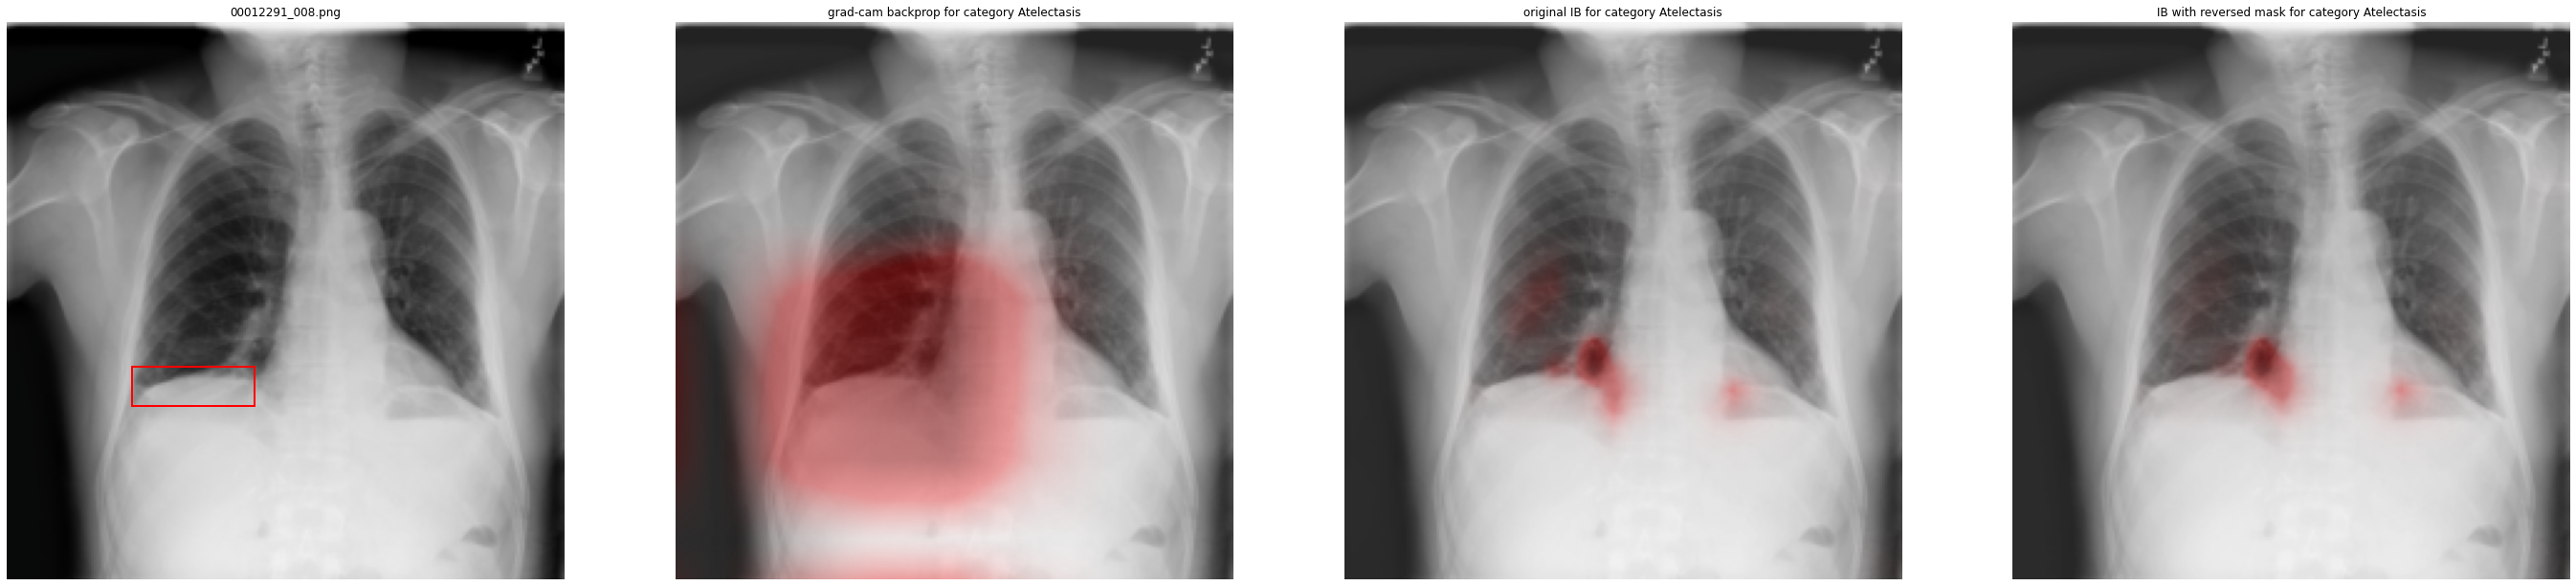

                   Predicted Probability  Ground Truth
Finding                                               
Atelectasis                        0.650          True
Effusion                           0.296         False
Infiltration                       0.169         False
Pneumothorax                       0.086         False
Pleural_Thickening                 0.034         False
Consolidation                      0.023         False
Emphysema                          0.023         False
Fibrosis                           0.021         False
Nodule                             0.020         False
Pneumonia                          0.011         False
Mass                               0.008         False
Edema                              0.005         False
Hernia                             0.005         False
Cardiomegaly                       0.002         False


In [ ]:
visualization_comparison()

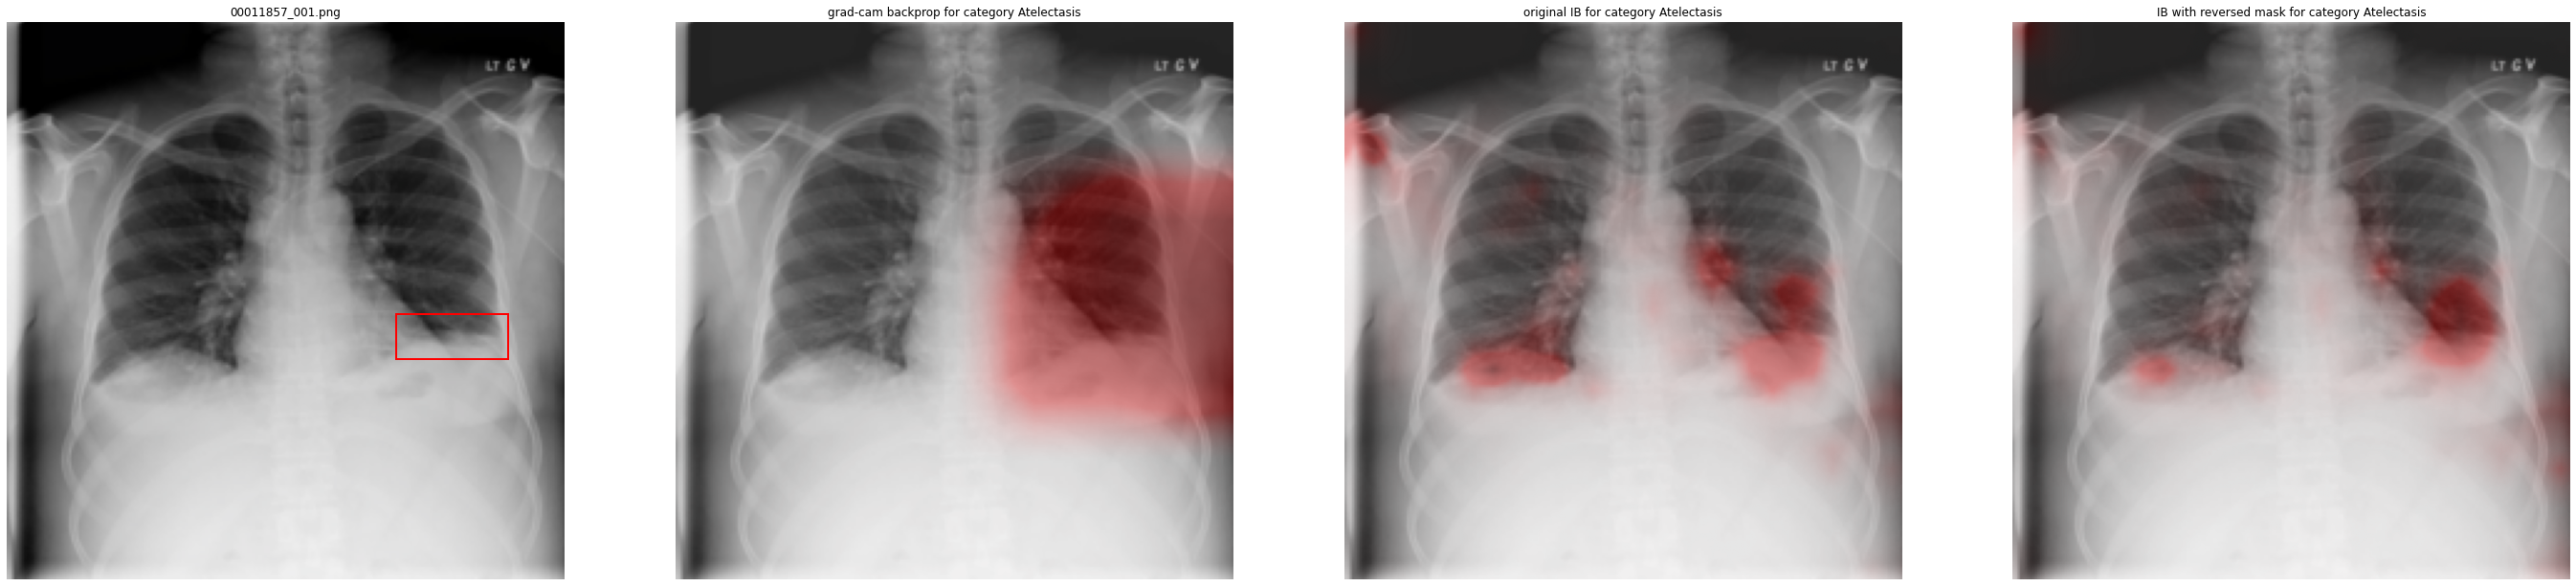

                   Predicted Probability  Ground Truth
Finding                                               
Effusion                           0.712          True
Atelectasis                        0.294          True
Mass                               0.196         False
Infiltration                       0.150          True
Consolidation                      0.072          True
Nodule                             0.068         False
Pleural_Thickening                 0.049         False
Cardiomegaly                       0.042         False
Pneumonia                          0.022         False
Edema                              0.017         False
Pneumothorax                       0.014         False
Fibrosis                           0.010         False
Hernia                             0.004         False
Emphysema                          0.002         False


In [ ]:
visualization_comparison()

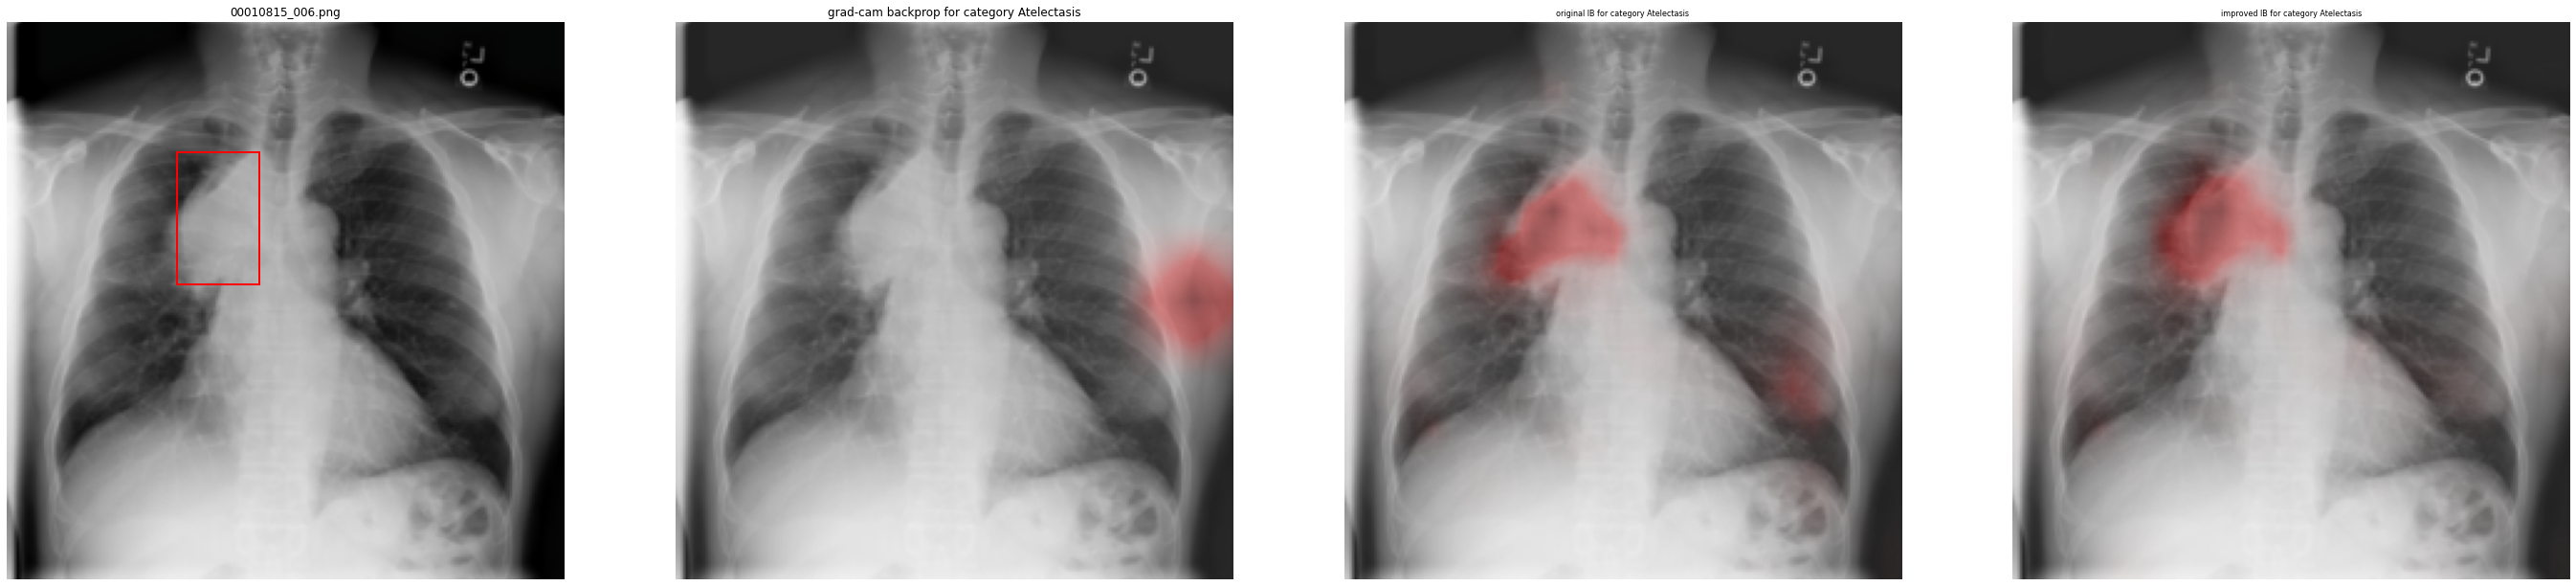

                   Predicted Probability  Ground Truth
Finding                                               
Mass                               0.688          True
Pleural_Thickening                 0.137         False
Effusion                           0.083         False
Atelectasis                        0.068          True
Infiltration                       0.065         False
Consolidation                      0.041         False
Nodule                             0.036         False
Fibrosis                           0.036         False
Pneumothorax                       0.017         False
Cardiomegaly                       0.016         False
Emphysema                          0.013         False
Pneumonia                          0.005         False
Hernia                             0.005         False
Edema                              0.002         False


In [ ]:
visualization_comparison()

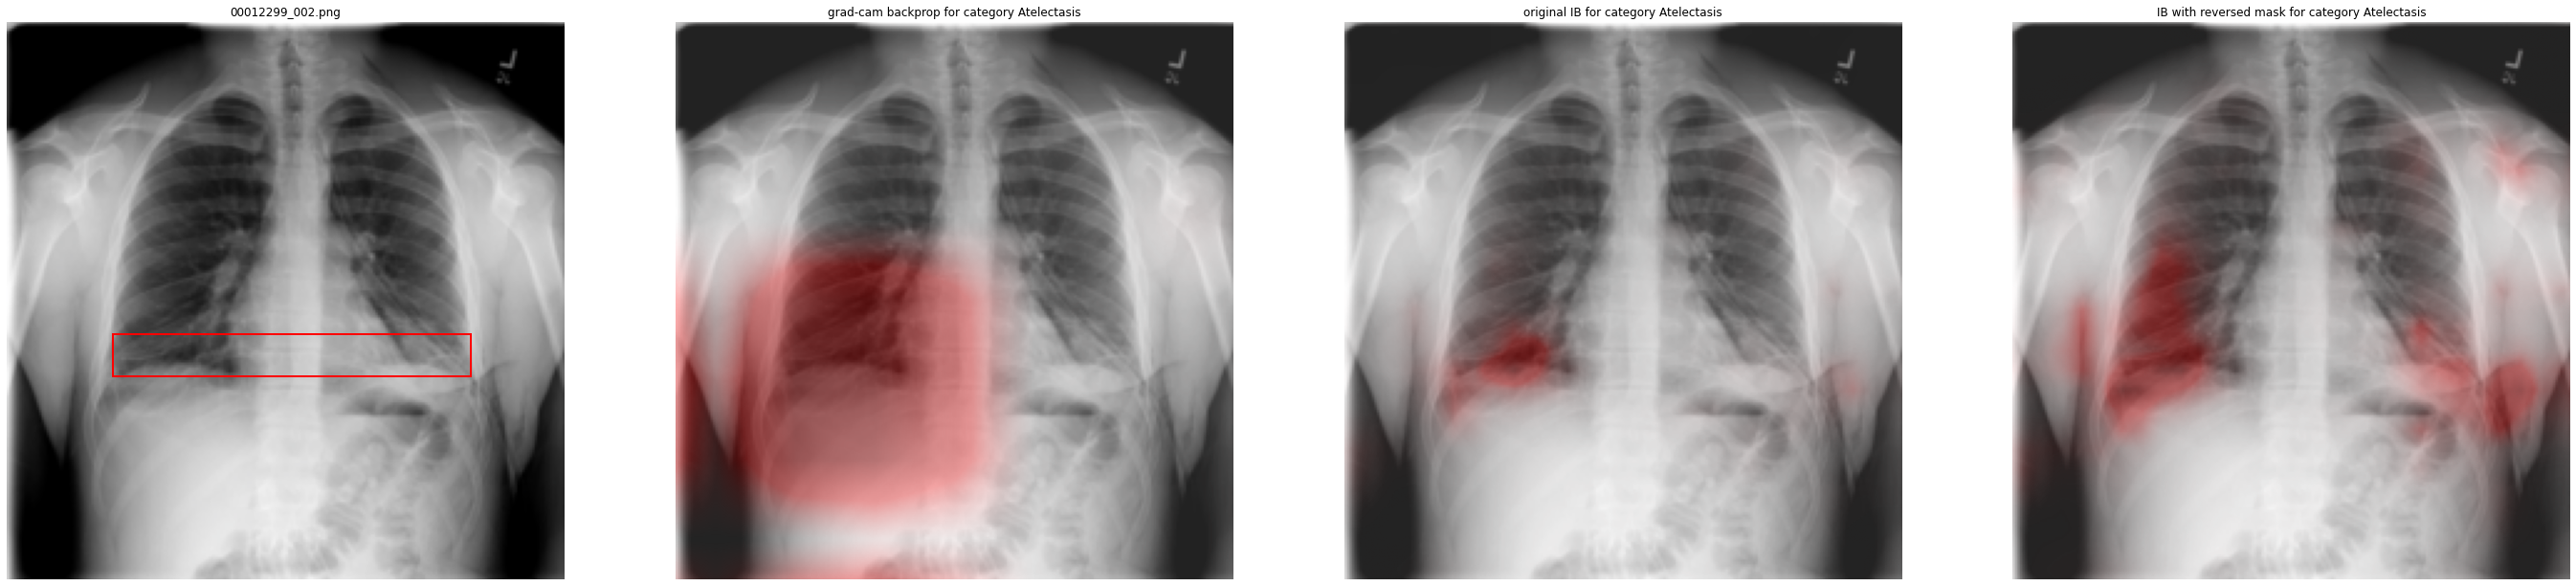

                   Predicted Probability  Ground Truth
Finding                                               
Pneumothorax                       0.634         False
Atelectasis                        0.451          True
Effusion                           0.239         False
Emphysema                          0.178         False
Infiltration                       0.109         False
Pleural_Thickening                 0.065         False
Mass                               0.061         False
Consolidation                      0.049         False
Nodule                             0.044         False
Fibrosis                           0.022         False
Pneumonia                          0.011         False
Edema                              0.007         False
Hernia                             0.002         False
Cardiomegaly                       0.001         False


In [ ]:
visualization_comparison()